# Demand forecasting with the Temporal Fusion Transformer

In this tutorial, we will train the Temporal Fusion Transformer on a very small dataset to demonstrate that it even does a good job on
only 20k samples. Generally speaking, it will perform much better with more data.

Our example is a demand forecast from the [Stallion kaggle competition](https://www.kaggle.com/utathya/future-volume-prediction).

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

os.chdir("../../..")

In [2]:
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import copy


import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateLogger
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Load data

In [3]:
from examples.data import get_stallion_data

data = get_stallion_data()

data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)

data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "", 1: x.name})).astype("category")


### Create dataset and dataloaders

In [4]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=0,  # allow encoder lengths from 0 to max_prediction_length
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["volume", "log_volume", "industry_volume", "soda_volume", "avg_max_temp"],
    target_normalizer=GroupNormalizer(groups=["agency", "sku"], coerce_positive=1.0),  # use softplus with beta=1.0 and normalize by group
)


validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Create baseline model

In [5]:
# calculate baseline absolute error
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

## Run PyTorch Forecasting model

### Find optimal learning rate

In [6]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateLogger()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    early_stop_callback=early_stop_callback,
    #     limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger],
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
#     log_interval=10,  # uncomment learning rate finder and otherwise to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 28.0k


/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Warning, `module_arguments` dropped from checkpoint. An attribute is not picklable Can't pickle local object '_apply_to_outputs.<locals>.decorator_fn.<locals>.new_func'
  warnings.warn(*args, **kwargs)

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | input_embeddings                   | ModuleDict                      | 1 K   
2  | prescalers                         | ModuleDict                      | 224   
3  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
4  | encoder_variable_selection         | VariableSelectionNetwork        | 6 K   
5  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
6  | st

/Users/distiller/project/conda/conda-bld/pytorch_1591914925853/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
LR finder stopped early due to diverging loss.


suggested learning rate: 6.918309709189365e-06


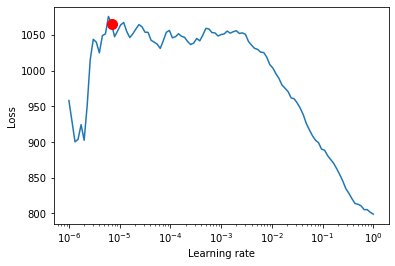

/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


In [7]:
# find optimal learning rate
res = trainer.lr_find(
    tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=1.0, min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model

In [8]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateLogger()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=20,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    early_stop_callback=early_stop_callback,
        limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger],
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment learning rate finder and otherwise to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 28.0k


We can now fit the network and monitor its training with tensorboard. Execute
`tensorboard --logdir=lightning_logs` to bring up the tensorboard dashboard to visualize training.

In [9]:
# fit network
trainer.fit(
    tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | input_embeddings                   | ModuleDict                      | 1 K   
2  | prescalers                         | ModuleDict                      | 224   
3  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
4  | encoder_variable_selection         | VariableSelectionNetwork        | 6 K   
5  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
6  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
7  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
8  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K   
9  | static_context_enrichment          | GatedResidualNetwork            | 1 K 

/Users/distiller/project/conda/conda-bld/pytorch_1591914925853/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/beitnerjan/opt/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

1

## Evaluate performance

In [10]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Our model performs better than the baseline model (given the noisy data, this is not trivial)

In [11]:
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(274.1958)

We can now also look at sample predictions directly and even evaluate at which input samples the model attends most to make a forecast.

In [12]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

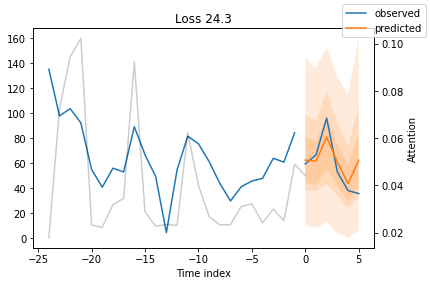

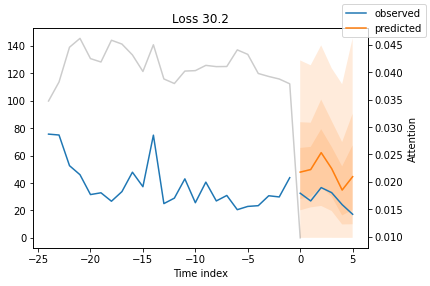

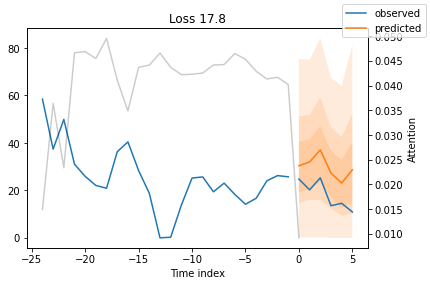

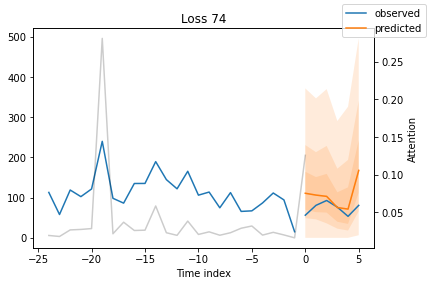

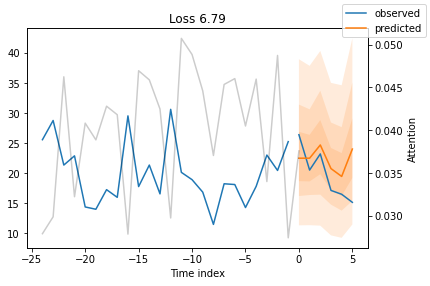

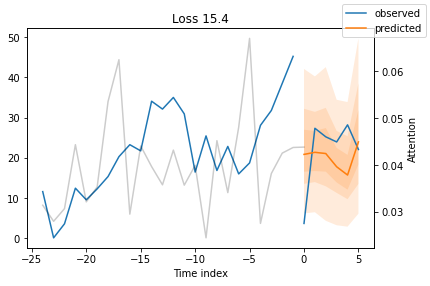

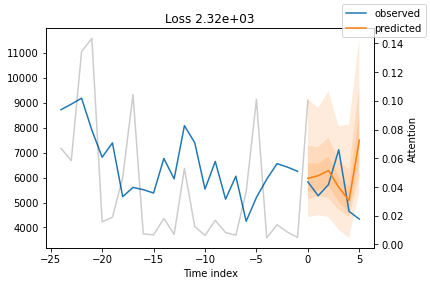

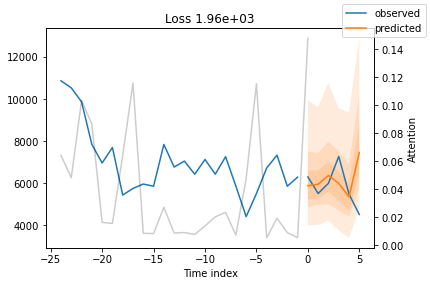

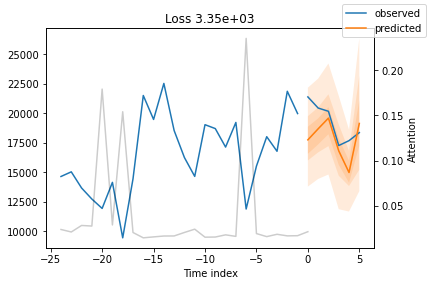

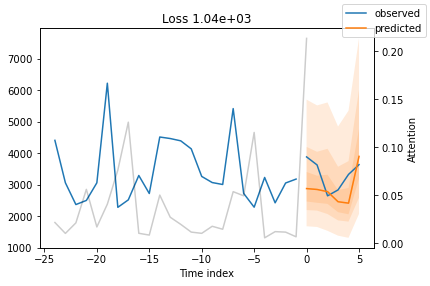

In [13]:
for idx in range(10):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Interpret model

The model has inbuilt interpretation capabilities due to how its architecture is build. Let's see how that looks.

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>,
 'encoder_variables': <Figure size 504x342 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

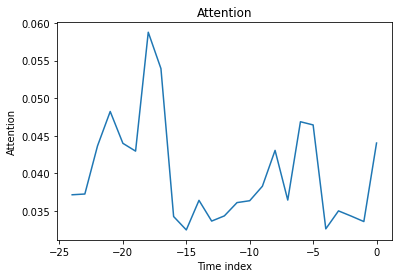

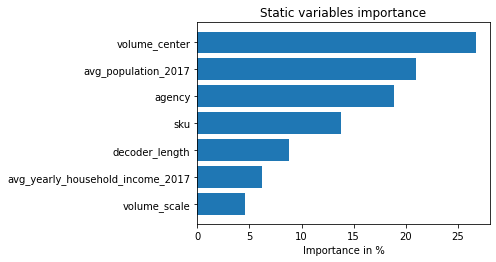

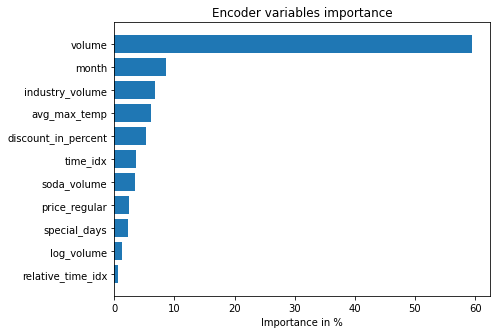

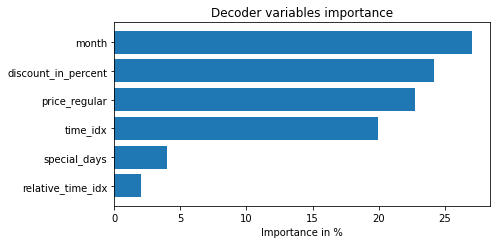

In [14]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

### Worst performers

Calculating where our model performs poorly, we see that those are really difficult cases to forecast

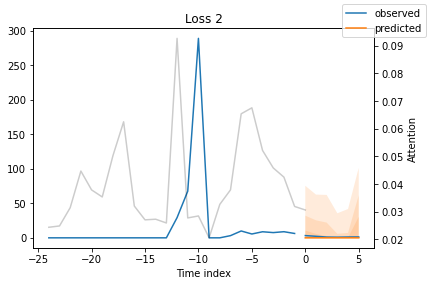

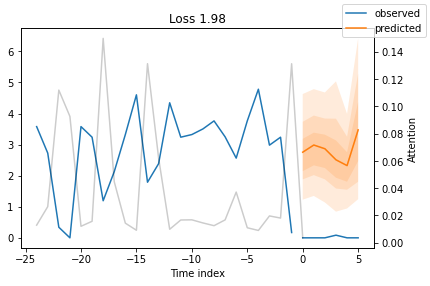

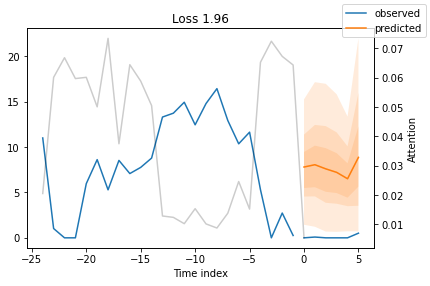

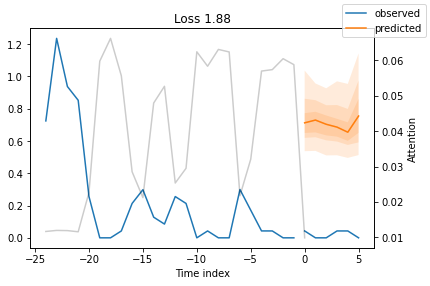

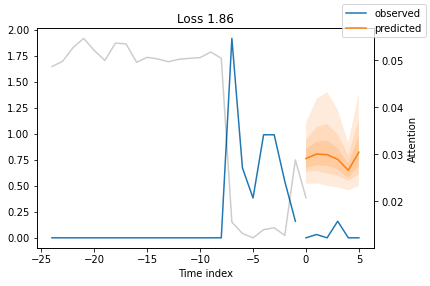

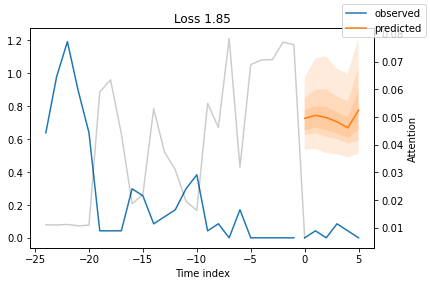

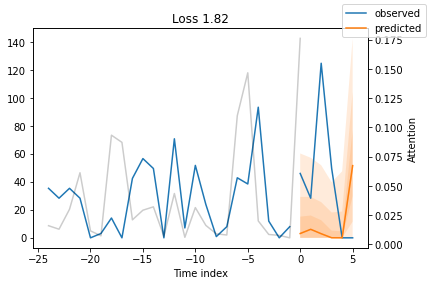

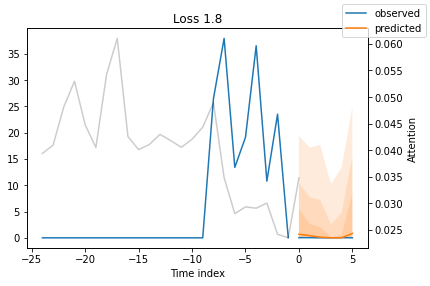

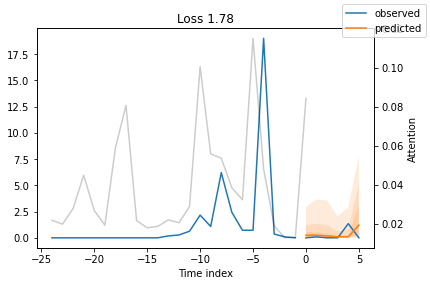

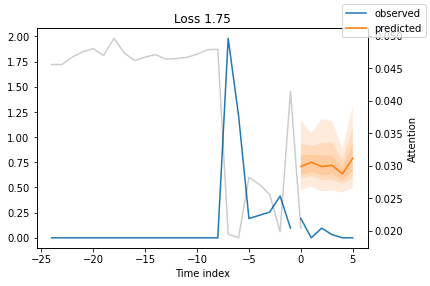

In [15]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());